In [56]:
# COMP257 - Unsupervised Learning (Assignment 6)
# Name: Wai Lim Leung
# ID  : 301276989
# Date: 12-Dec-2023

In [57]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet xvfbwrapper

!pip install swig
!pip install gymnasium[box2d]

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already th

In [58]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

display = pyvirtualdisplay.Display(visible=0, size=(1500, 1000)).start()

In [59]:
# Environment Name
env_name = "LunarLander-v2"

num_iterations = 250
collect_episodes_per_iteration = 2
replay_buffer_capacity = 2000

fc_layer_params = (100,)

learning_rate = 1e-3
log_interval = 25
num_eval_episodes = 10
eval_interval = 50

In [60]:
import gym
import gym.spaces as sp
env_wailim = gym.make(env_name)

In [61]:
env_wailim.observation_space

Box(-inf, inf, (8,), float32)

In [62]:
env_wailim.seed(89)
obs = env_wailim.reset()
obs

array([ 0.00626698,  1.4042997 ,  0.63476515, -0.29425955, -0.00725512,
       -0.14378378,  0.        ,  0.        ], dtype=float32)

In [63]:
env_wailim.action_space

Discrete(4)

In [64]:
import keras
keras.backend.clear_session()
np.random.seed(89)
tf.random.set_seed(89)

model_input = env_wailim.observation_space.shape[0]
model_output = env_wailim.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=[model_input]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(model_output, activation="softmax"),
])

In [68]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(action[0, 0].numpy())
    return obs, reward, done, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    rewards_all = []
    grads_all = []
    for episode in range(n_episodes):
        rewards_current = []
        grads_current = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = lander_play_one_step(env, obs, model, loss_fn)
            rewards_current.append(reward)
            grads_current.append(grads)
            if done:
                break
        rewards_all.append(rewards_current)
        grads_all.append(grads_current)
    return rewards_all, grads_all

In [70]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [71]:
n_iterations = 20
n_episodes_per_update = 16
n_max_steps = 500
discount_rate = 0.99

In [72]:
optimizer = keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

In [74]:
env_wailim.seed(89)
mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env_wailim, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print("\rIteration: {}/{}, Mean Reward: {:.1f}  ".format(
        iteration + 1, n_iterations, mean_reward), end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 20/20, Mean Reward: -101.3  

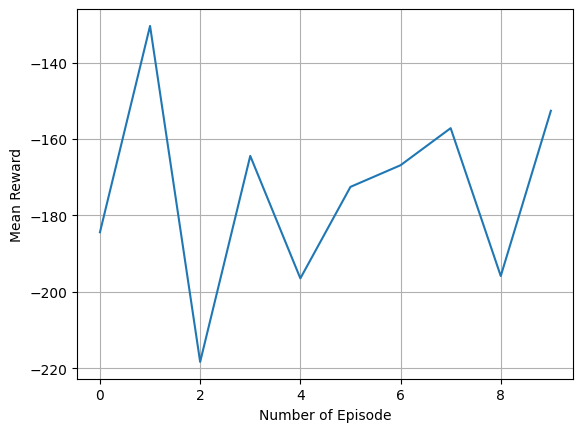

In [52]:
import matplotlib.pyplot as plt

plt.plot(mean_rewards)
plt.xlabel("Number of Episode")
plt.ylabel("Mean Reward")
plt.grid()
plt.show()

In [53]:
def lander_render_policy_net(model, n_max_steps=500, seed=89):
    frames = []
    env = gym.make("LunarLander-v2")
    env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0, 0].numpy())
        if done:
            break
    env.close()
    return frames

In [54]:
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_animation(frames):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    plt.close()
    return HTML(anim.to_jshtml())

frames = lander_render_policy_net(model, seed=42)
display_animation(frames)